## Imports
If used on a new device will also need to install all below packages

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Point, LineString, Polygon
from sklearn.metrics import r2_score
import scipy
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Reading Files

In [2]:
#Read in Files - This takes a LONG time ~3mins. Do not run unless necessary
#Census Block Group base information
BG_raw = gpd.read_file('../CensusData/nhgis0006_shapefile_tl2020_us_blck_grp_2020.zip')
#plot base information
plots = pd.read_csv("../FIAData/ID_PLOT.csv")
#base tree information
trees = pd.read_csv("../FIAData/ID_TREE.csv")
#metro area information
metro = gpd.read_file('../MetroAreas/tl_2019_us_cbsa.zip')

## Entering Variables 
This should be the only edit when looking at different variables for trees, census, and differet summary statistics

In [3]:
#Set variables for what data and how it is aggregated as well as tree variable and aggregation
#Set variables for cities chosen.
data = pd.read_csv('../CensusData/nhgis0007_ds249_20205_blck_grp.csv') ## data to be read in
#Name of column in Dataframe
dataString = 'AMR8E001'
#name of folder and graphs
dataVars = 'Average Household Income'
#filter out unwanted data
filter0 = 0
#Name of Column in data frame
treeVar = 'SPCD'
#Aggregation statistic Currently only mean and sum are programed. Must program in others if want to use
howTree = 'unique'
#Name of folder and graphs
treeVars = "Number Tree Species"
#cities to execute
cities = ['Austin-Round Rock','Houston', 'San Antonio', 'Portland-Vancouver', 'San Diego', 'Springfield, MO', 'Kansas City', 'St. Louis', 'Washington-Arlington', 'Chicago']
city = 'San Antonio'
#Directory for images to be saved
parent_dir = "C:/Users/elimr/anaconda3/Environment/ResearchProject/UrbanFIAAnalysis/Figures"

### clean and fix plots data

In [4]:
### #add geometry and convert to geodataframe
geometry = gpd.points_from_xy((plots['LON']).astype(float),(plots['LAT']).astype(float))
plots['geometry'] = geometry 
plotsG = gpd.GeoDataFrame(plots, crs = "EPSG:4326" , geometry = geometry)
#convert to Albers
plotsG_A = plotsG.to_crs("ESRI:102003")

In [5]:
#Plot to look at all FIA plots
#fig, ax = plt.subplots(figsize=(6, 6))
#plt.title("FIA Plots")
#plotsBase = plotsG_A.plot(ax = ax, kind = 'geo',markersize=1)
#cx.add_basemap(plotsBase,crs="ESRI:102003")

### Clean and fix tree data.

Create dictionary of tree species and assign to trees

In [6]:
import csv
reader = csv.DictReader(open("../FIAData/REF_SPECIES.csv"))
mydict = {rows['SPCD']:rows['COMMON_NAME'] for rows in reader}
trees2 = trees
trees2['name'] = trees2['SPCD'].astype(str)
trees2=trees2.replace({"name": mydict})

### Clean and fix block group data, Merge plots to block groups

In [7]:
#Create County State variable which reduces time by removing uncessary census block groups
plotsG_A['CountSt'] = plotsG_A['COUNTYCD'] * 100 + plotsG_A['STATECD']
BG_raw['CountSt'] = BG_raw['COUNTYFP'].astype(int) * 100 + BG_raw['STATEFP'].astype(int)
#Merge census data to Block groups
BG_merged = pd.merge(data,BG_raw,on='GISJOIN')
#Merge tree data to block groups on created columns
BG = BG_merged[(BG_merged.CountSt).isin(plotsG_A['CountSt'])]
#Convert to geo data frame
BG = gpd.GeoDataFrame(BG, crs = "ESRI:102003" , geometry = BG['geometry'])

In [8]:
#Show Census Blocks
#fig, ax = plt.subplots(figsize=(6, 6))
#plt.title("Census Blocks")
#BGBase = BG.plot(ax = ax, kind = 'geo',alpha = .5, aspect=1, edgecolor = "black")
#cx.add_basemap(BGBase,crs="ESRI:102003")

### Perform geospatial analysis
1. buffer plots
2. intersect plots and block groups
3. dissolve intersect
4. merge back to trees

In [9]:
#create new data frame for buffer to fill
buffer = plotsG_A.copy()
#create a series of our plots geometries and convert crs to albers
#Needs to be a geoseries which is why directly referencing the column did not work
series = gpd.GeoSeries(plotsG_A.geometry)
series = series.to_crs("ESRI:102003")
#buffer the geometry by 1km - 1000m
buffer['geometry'] = series.buffer(1000)
#Convert buffer to geodataframe
bufferG = gpd.GeoDataFrame(buffer, crs = "ESRI:102003" , geometry = buffer['geometry']) 
#simplify BG information to just geometry and data.
BGData = BG[['geometry', dataString,'Shape_Area']]
#Overlay block group on or buffer. This intersects block groups and plots buffer.
overlay = BGData.overlay(bufferG,how='intersection')
overlay['Area'] = overlay.area
overlay[dataString] = overlay['Area'] * overlay[dataString]
#Dissolve by plots. Now 1 measuring area per plot with aggregation statistic sum set at top
dissolve = overlay.dissolve(by = 'PLOTID', aggfunc = {dataString: 'sum'})
dissolve[dataString] = dissolve[dataString] / dissolve.area
dissolve = dissolve.loc[dissolve[dataString].notnull()]

In [10]:
moneyTree = pd.merge(trees2,dissolve,on='PLOTID')
geometry = moneyTree['geometry']
treesG = gpd.GeoDataFrame(moneyTree, crs = "ESRI:102003" , geometry = geometry)
treesG[dataString] = treesG[dataString]/1000

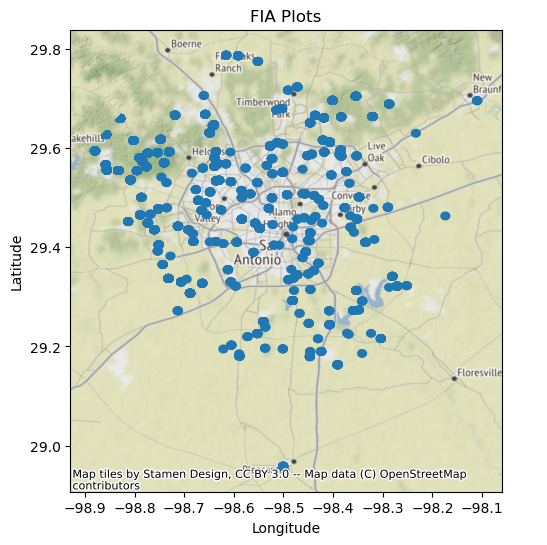

In [11]:
metroA = metro.to_crs("ESRI:102003")
metroCity = metroA[metroA['NAME'].str.contains(city)]
#Clip plots by selected city
clip = gpd.clip(treesG,metroCity)
clip = clip.to_crs('epsg:4326')
#Show final FIA pltos
fig, ax = plt.subplots(figsize=(6,6))
plt.title("FIA Plots")
plotBase = clip.plot(ax = ax, kind = 'geo')
cx.add_basemap(plotBase,crs = "epsg:4326")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('Figures/Plots/SanAntonio.png',bbox_inches='tight')
plt.show()


# Spatial Autocorrelation

# Statistics

In [12]:
#metroA = metro.to_crs("ESRI:102003")
#metroCity = metroA[metroA['NAME'].str.contains(city)]
#Clip plots by selected city
#clip = gpd.clip(treesG,metroCity)

## Loop and print data for all cities

In [13]:
def tukeyLetters(pp, means=None, alpha=0.05):
    #TUKEYLETTERS - Produce list of group labels for TukeyHSD
    #letters = TUKEYLETTERS(pp), where PP is a symmetric matrix of 
    #probabilities from a Tukey test, returns alphabetic labels
    #for each group to indicate clustering. PP may also be a vector
    #from PAIRWISE_TUKEYHSD.
    #Optional argument MEANS specifies group means, which is used for
    #ordering the letters. ("a" gets assigned to the group with lowest
    #mean.) Without this argument, ordering is arbitrary.
    #Optional argument ALPHA specifies cutoff for treating groups as
    #part of the same cluster.'''

    if len(pp.shape)==1:
        # vector
        G = int(3 + np.sqrt(9 - 4*(2-len(pp))))//2
        ppp = .5*np.eye(G)
        ppp[np.triu_indices(G,1)] = pp    
        pp = ppp + ppp.T
    conn = pp>alpha
    G = len(conn)
    if np.all(conn):
        return ['a' for g in range(G)]
    conns = []
    for g1 in range(G):
        for g2 in range(g1+1,G):
            if conn[g1,g2]:
                conns.append((g1,g2))

    letters = [ [] for g in range(G) ]
    nextletter = 0
    for g in range(G):
        if np.sum(conn[g,:])==1:
            letters[g].append(nextletter)
            nextletter += 1
    while len(conns):
        grp = set(conns.pop(0))
        for g in range(G):
            if all(conn[g, np.sort(list(grp))]):
                grp.add(g)
        for g in grp:
            letters[g].append(nextletter)
        for g in grp:
            for h in grp:
                if (g,h) in conns:
                    conns.remove((g,h))
        nextletter += 1

    if means is None:
        means = np.arange(G)
    means = np.array(means)
    groupmeans = []
    for k in range(nextletter):
        ingroup = [g for g in range(G) if k in letters[g]]
        groupmeans.append(means[np.array(ingroup)].mean())
    ordr = np.empty(nextletter, int)
    ordr[np.argsort(groupmeans)] = np.arange(nextletter)
    result = []
    for ltr in letters:
        lst = [chr(97 + ordr[x]) for x in ltr]
        lst.sort()
        result.append(''.join(lst))
    return result

Folder Exists - Skipping to Graphs
['a', 'b', 'b', 'c', 'c']


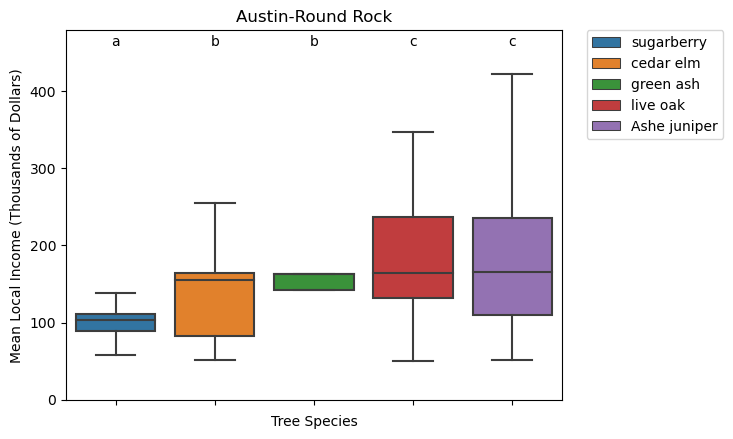

['a', 'ab', 'bc', 'abc', 'c']


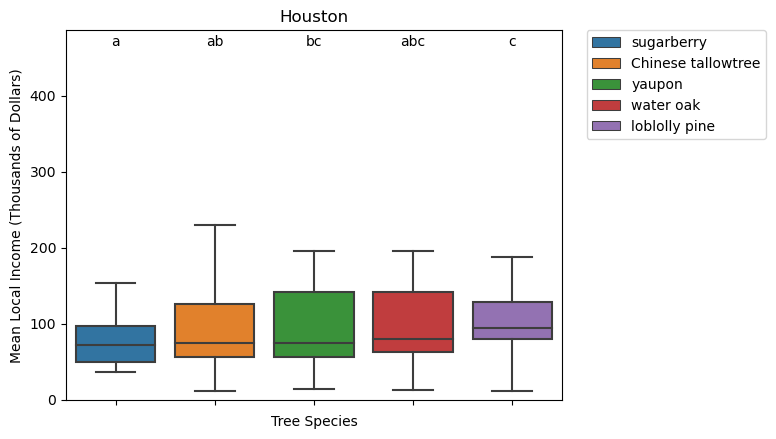

['a', 'a', 'a', 'b', 'c']


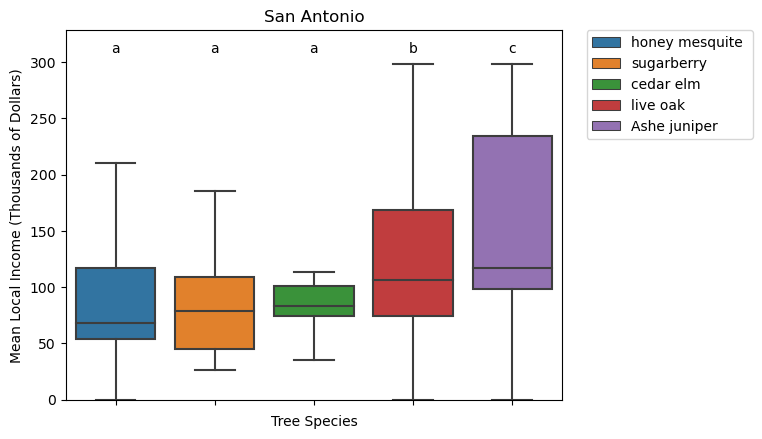

['a', 'ab', 'c', 'bc', 'c']


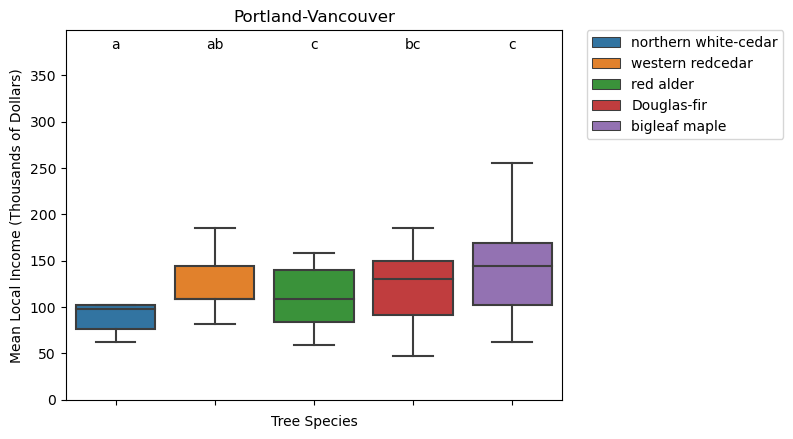

['a', 'a', 'a', 'a', 'b']


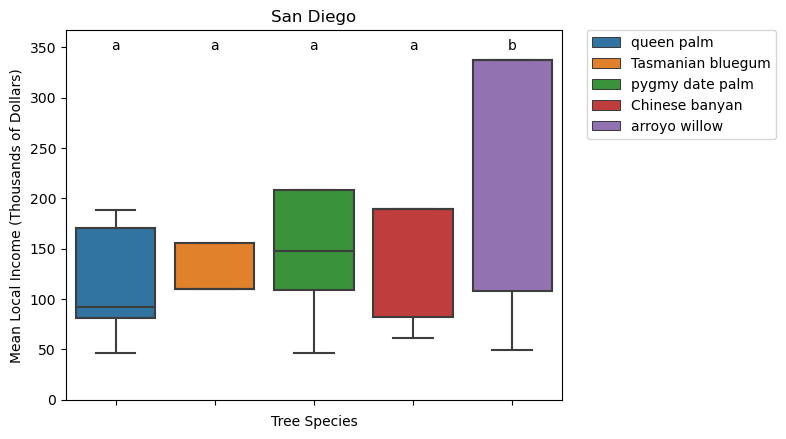

['a', 'a', 'a', 'a', 'a']


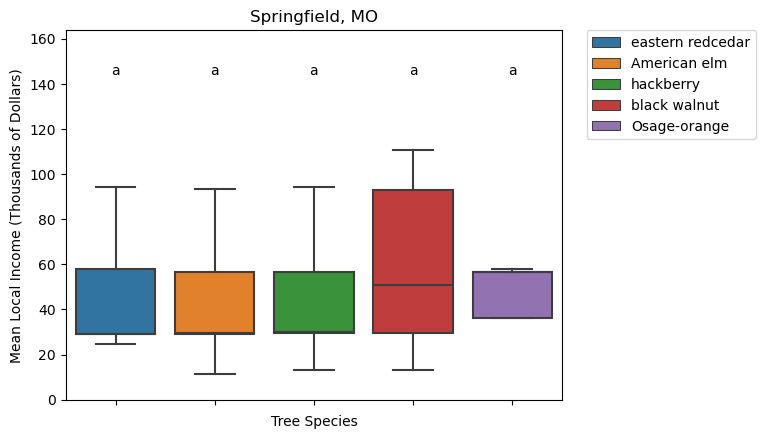

['a', 'a', 'b', 'b', 'b']


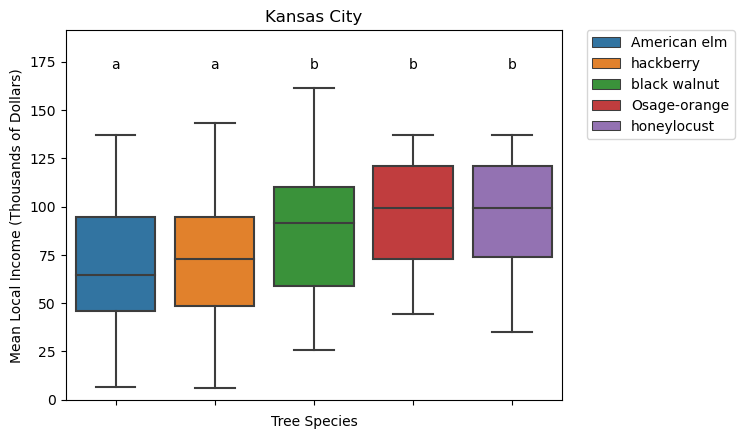

['a', 'ab', 'b', 'b', 'ab']


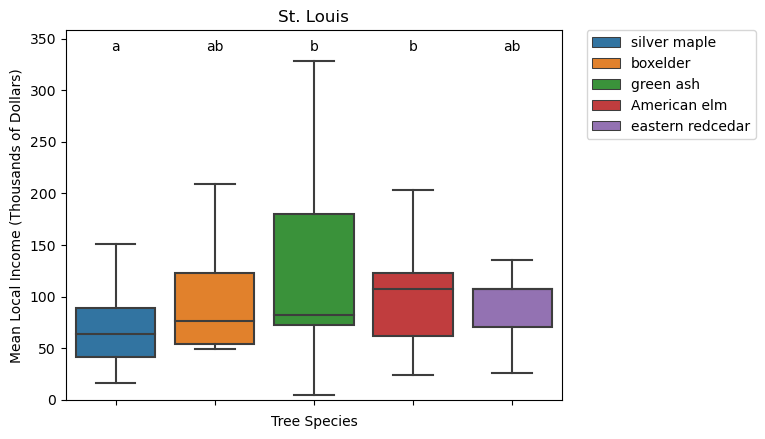

['a', 'ab', 'b', 'bc', 'c']


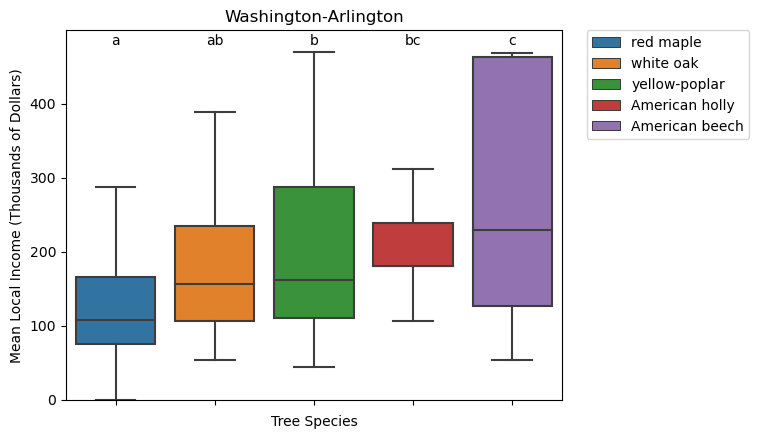

['a', 'ab', 'bc', 'c', 'c']


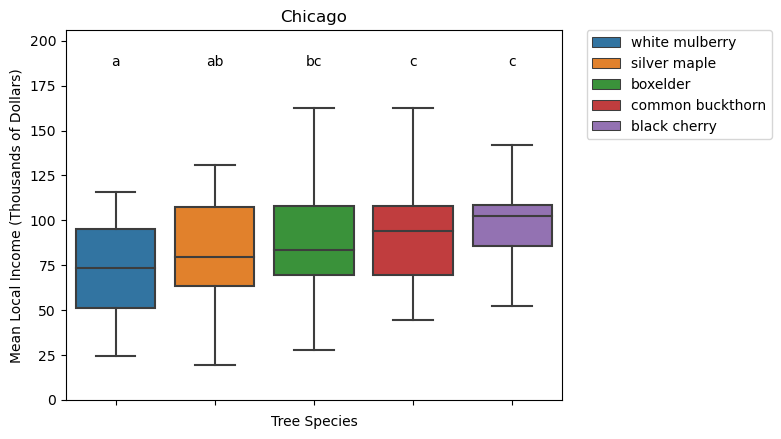

In [35]:
#Create directory to store figures
# Directory 
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import tukey_hsd

directory = 'Species Diversity Boxplots'
# Path - Parent dir set in variables at top
path = os.path.join(parent_dir, directory) 
try: 
    os.mkdir(path) 
except OSError as error: 
    print("Folder Exists - Skipping to Graphs")  
#Convert metro area information to albers
metroA = metro.to_crs("ESRI:102003")
#filter metro information for only cities needed
metroA = metroA[metroA['NAME'].str.contains('|'.join(cities))]
for i in range(len(cities)):
    city = cities[i]
    #filter metro area again for specific city.
    metroCity = metroA[metroA['NAME'].str.contains(city)]
    #Clip plots by selected city
    clip = gpd.clip(treesG,metroCity)
    
    #Filter trees by number of trees
    #counts_trees = clip.groupby("name")["name"].transform(len)
    #mask = (counts_trees > 50)
    #clip = clip[mask]
    
    #Filter trees by most common occuring trees
    n = 5
    trees5 = clip['name'].value_counts()[:n].index.tolist()
    clip = clip[clip['name'].isin(trees5)]
    my_order = clip.groupby(by=["name"])[dataString].median().sort_values().index
    tree1 = clip.loc[clip['name']==my_order[0]][dataString]
    tree2 =  clip.loc[clip['name']==my_order[1]][dataString]
    tree3 =  clip.loc[clip['name']==my_order[2]][dataString]
    tree4 =  clip.loc[clip['name']==my_order[3]][dataString]
    tree5 =  clip.loc[clip['name']==my_order[4]][dataString]
    anova = f_oneway(tree1, tree2, tree3, tree4, tree5)
    p = anova.pvalue
    tukey = tukey_hsd(tree1, tree2, tree3, tree4, tree5)
    letters = tukeyLetters(tukey.pvalue)


    #Plot species diversity against income
    g = sns.boxplot(data=clip, x='name', y=dataString, hue='name',
                dodge=False, palette=sns.color_palette(),
                order = my_order, hue_order = my_order, fliersize = 0)

    for i in range(len(letters)):
        g.annotate(letters[i],xy = (i,clip[dataString].max()+10), ha='center')
    # annotate
    plt.ylim(0, clip[dataString].max()+30)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad = 0)
    plt.title(city)
    plt.xlabel('Tree Species')
    plt.ylabel('Mean Local Income (Thousands of Dollars)')
    g.set_xticklabels('')
    #Save figures to directory
    plt.savefig('Figures/'+ directory + '/' +city+ '.png',bbox_inches='tight')
    #plt.close()
    plt.show()


# Tree Dist Map

In [15]:
#Filter trees by most common occuring trees
treePlot = trees2.groupby('PLOTID')['name'].agg(pd.Series.mode)
plotSpecies = pd.merge(plotsG_A,treePlot,on='PLOTID')
for i in range(len(plotSpecies)):
    if(not(isinstance(plotSpecies['name'][i],str))):
        plotSpecies['name'][i] = plotSpecies['name'][i][0]

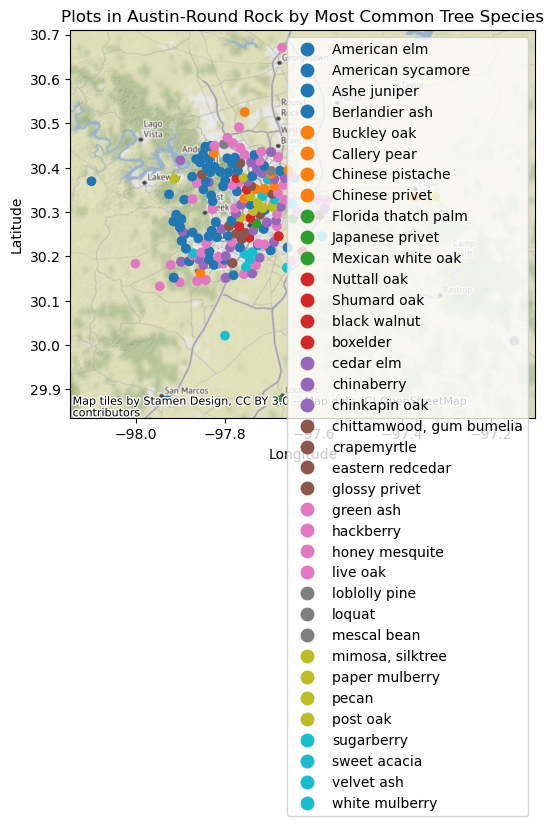

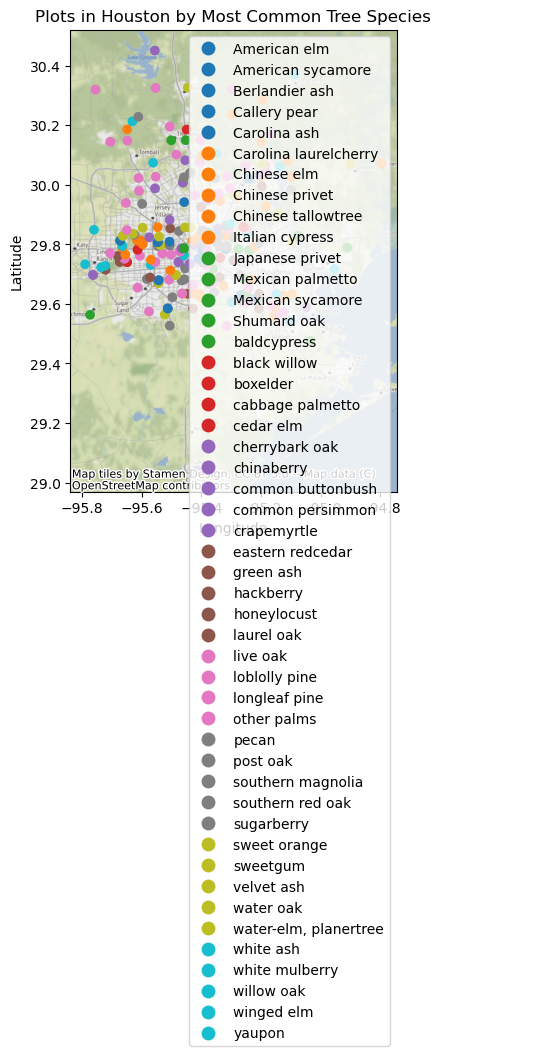

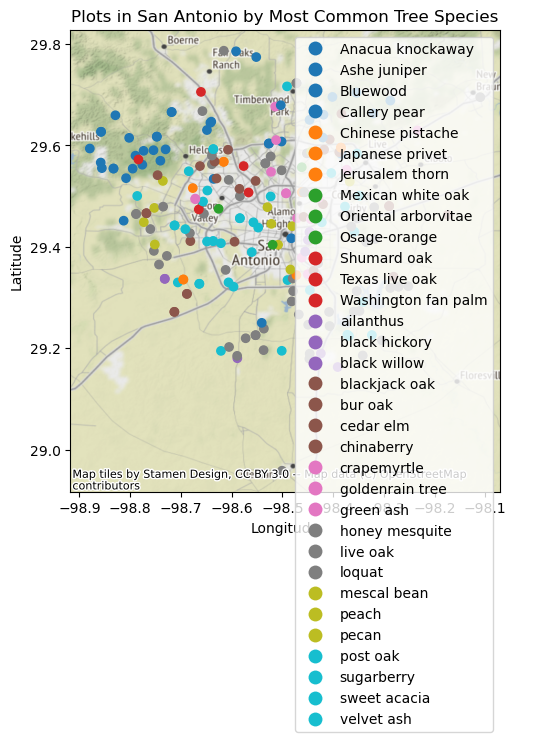

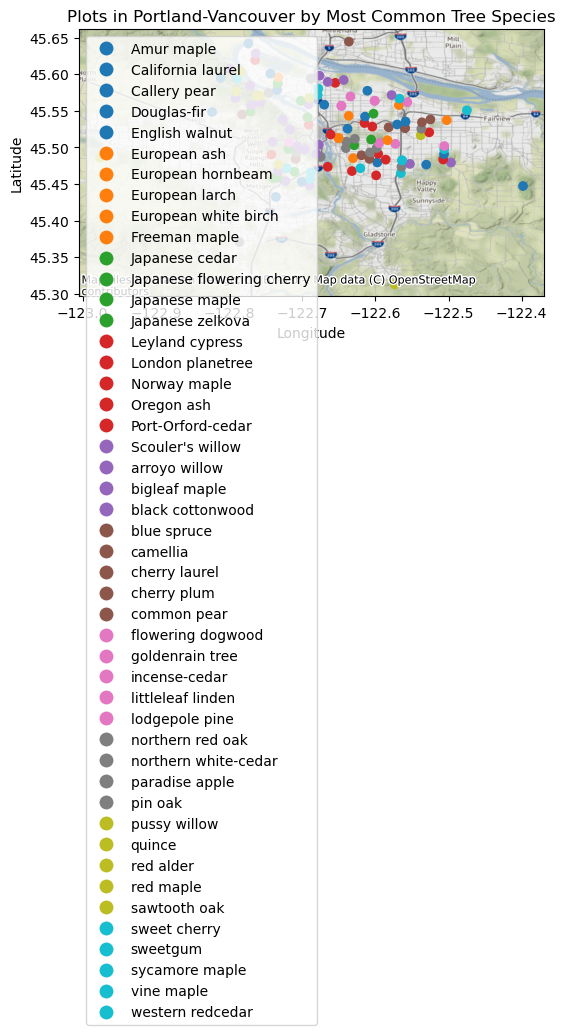

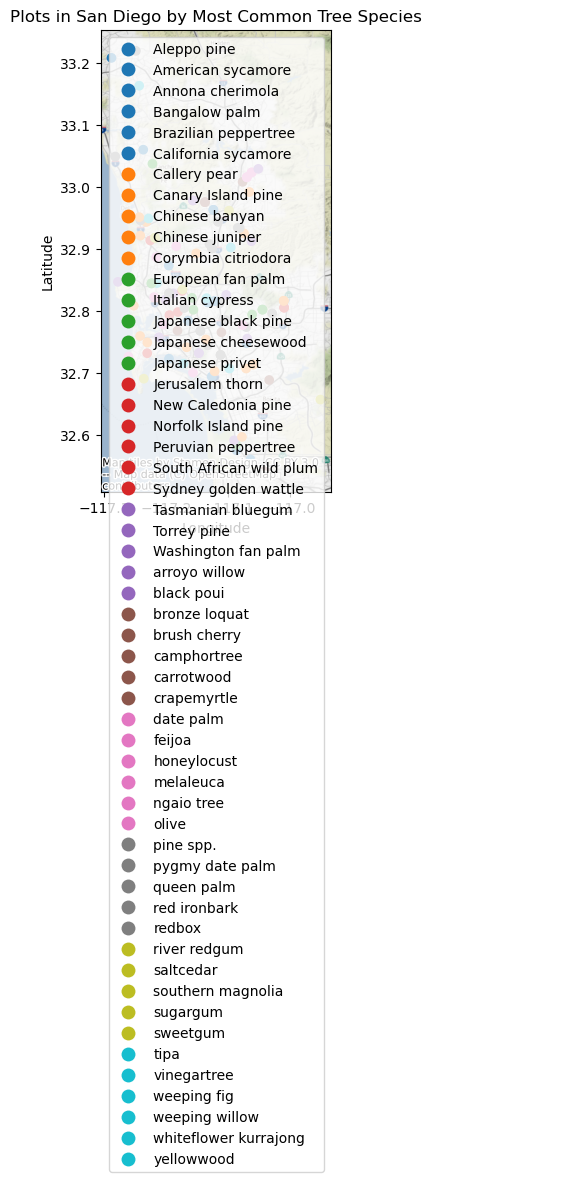

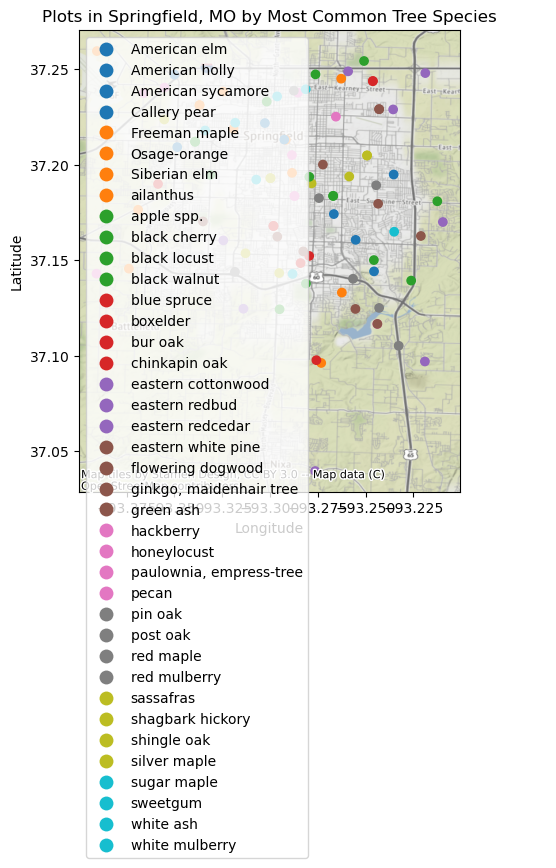

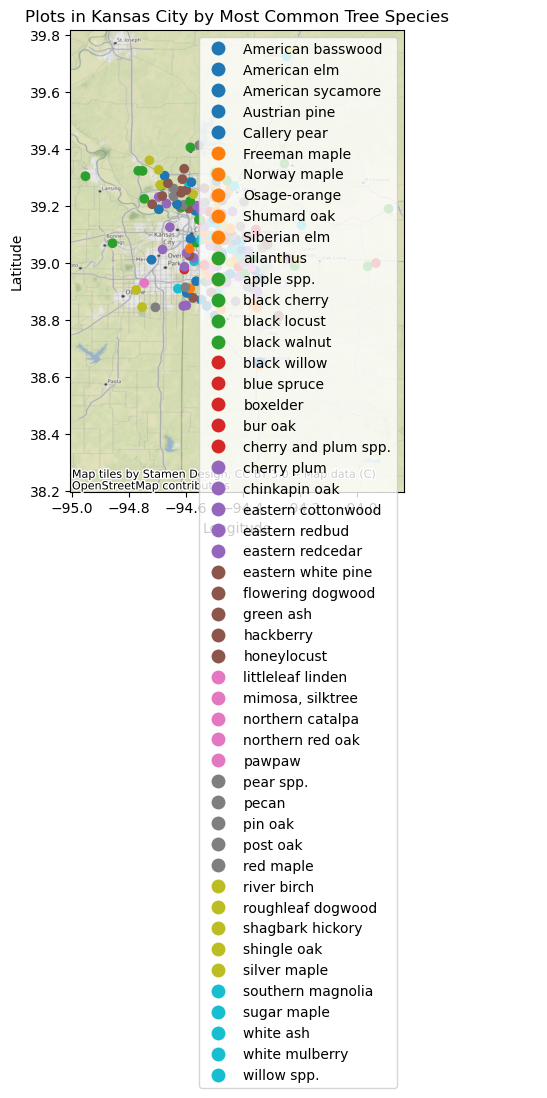

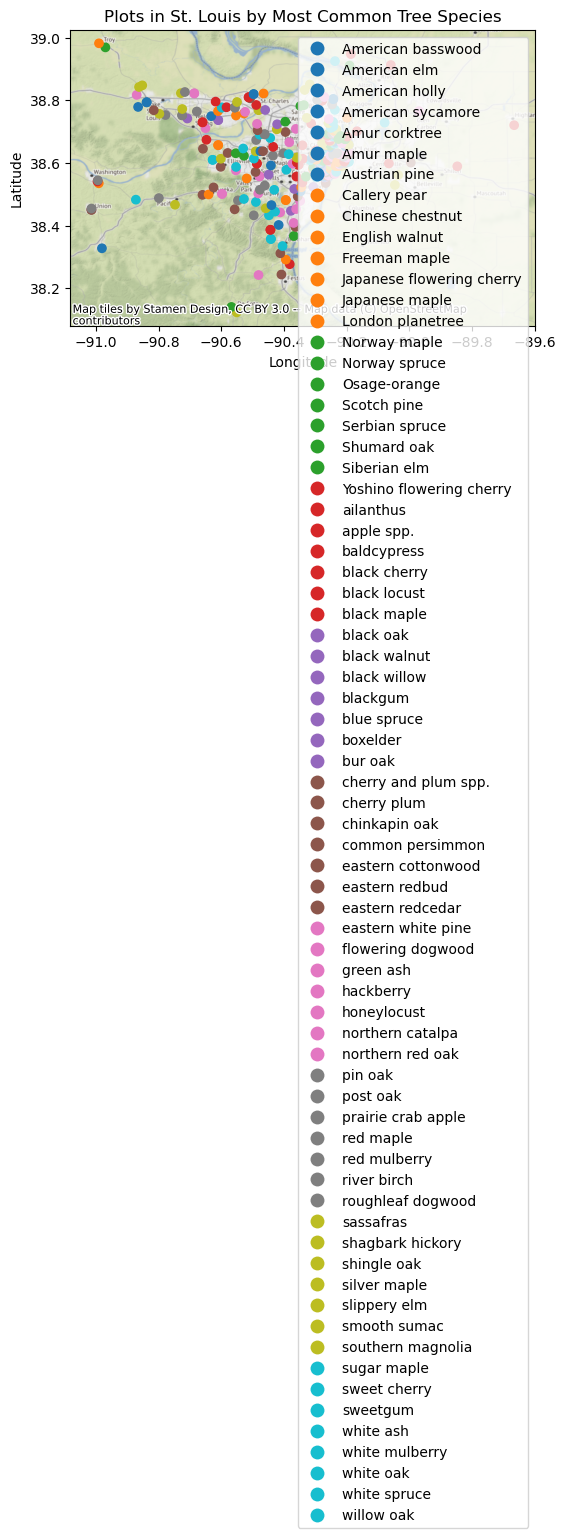

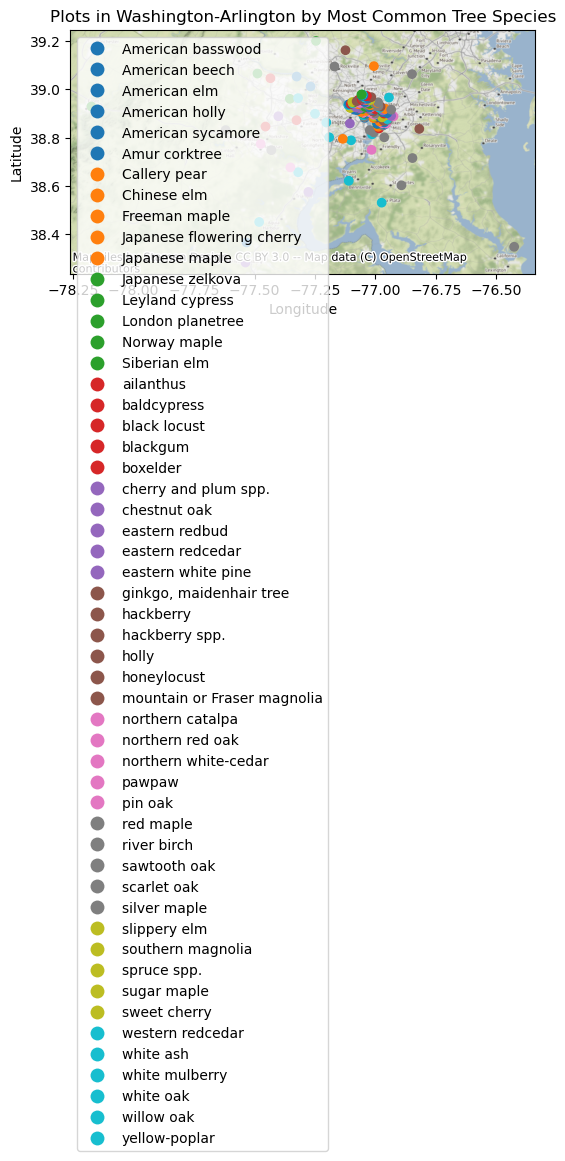

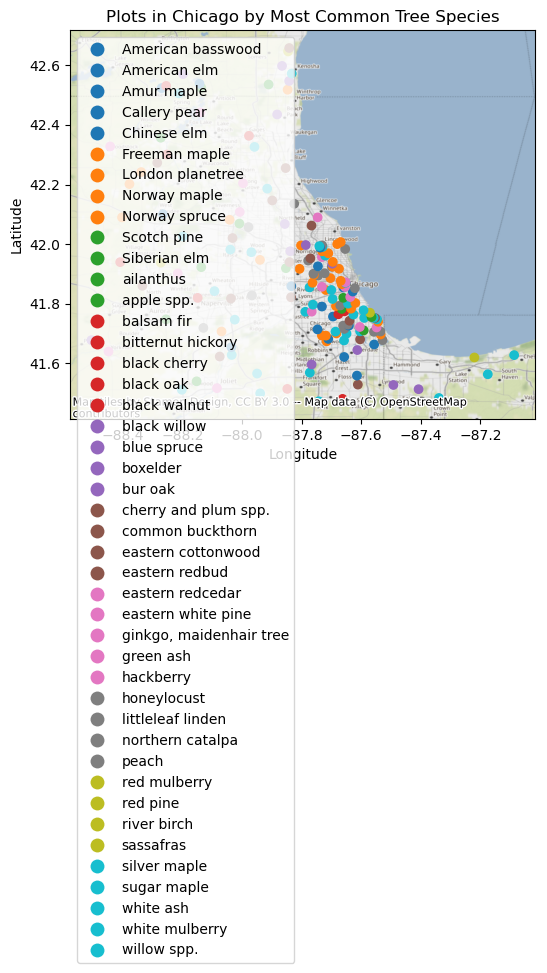

In [16]:
metroA = metro.to_crs("ESRI:102003")
for i in range(len(cities)):
    city = cities[i]
    metroCity = metroA[metroA['NAME'].str.contains(city)]
    #Clip plots by selected city
    clip = gpd.clip(plotSpecies,metroCity)
    clip = clip.to_crs('epsg:4326')
    #Show final FIA pltos
    fig, ax = plt.subplots(figsize=(6,6))
    plt.title("Plots in " + city + " by Most Common Tree Species")
    plotBase = clip.plot(ax = ax, column='name', kind = 'geo',legend=True)
    cx.add_basemap(plotBase,crs = "epsg:4326")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('Figures/Tree Distribution/'+city+'.png',bbox_inches='tight')
    plt.show()
    #plt.close()
